## Explore NER results notebook

This notebook does an exploratory check of the results to find out how many named entities were recognised in the different categories and which ones are more frequently mentioned.

### 1. Import and clean data

In [ ]:
import sys
sys.path.append('../util/') # import python preprocessing script
import pandas as pd
from pathlib import Path
import os
import json
import warnings
from preprocessing import replace_ngrams_with_unigrams_curated_phrases
warnings.filterwarnings('ignore')

path = Path(os.getcwd())
data_dir = os.path.join(path.parents[0], "data-files")

# Clean the results of the NER analysis.
# This function:
# 1. cleans the NER extraction results by removing false positives and non-frequently mentioned entities
# 2. adds a column to the named entity results file for single token representation of ngram named entities
# 3. replaces ngram entities and phrases in source texts with single token equivalents 
replace_ngrams_with_unigrams_curated_phrases('data.json',
                                             'abbr.json',
                                             'master-ner-results.csv',
                                             'ngram_replacements.json',
                                             'processed_ngram_ner_data.json',
                                             'master-ner-results-singletokens.csv')

df = pd.read_csv(os.path.join(data_dir, "master-ner-results-singletokens.csv"))

### 2. Display basic counts

In [10]:
# calculate the total no. of unique named entities
n = len(pd.unique(df['entity_as_single_token']))
print("no. of unique named entities : ", n)
# total unique named entities by entity type
df['entity_as_single_token'] = df['entity_as_single_token'].str.strip()
# after stripping does the count change?
n2 = len(pd.unique(df['entity_as_single_token']))
print("no. of unique named entities : ", n2)

no. of unique named entities :  11609
no. of unique named entities :  11609


In [11]:
entity_counts_by_type_df = df.groupby(['entity_type'])['entity_as_single_token'].nunique()
entity_counts_by_type_df

# relevant entity types:
# ----------------------
# FAC	building name
# GPE	geo-political entity
# LOC	location name
# NORP	affiliation
# ORG	organization name
# PERSON	person name

entity_type
FAC        229
GPE       2259
LOC       1224
NORP       184
ORG       5967
PERSON    2825
Name: entity_as_single_token, dtype: int64

In [12]:
# dataframes for each entity type
fac_df = df[df['entity_type'] == 'FAC']
gpe_df = df[df['entity_type'] == 'GPE']
loc_df = df[df['entity_type'] == 'LOC']
norp_df = df[df['entity_type'] == 'NORP']
org_df = df[df['entity_type'] == 'ORG']
per_df = df[df['entity_type'] == 'PERSON']
nonorg_df = pd.concat([fac_df, gpe_df, loc_df, norp_df, per_df], ignore_index=True)

Text(0, 0.5, 'Organization')

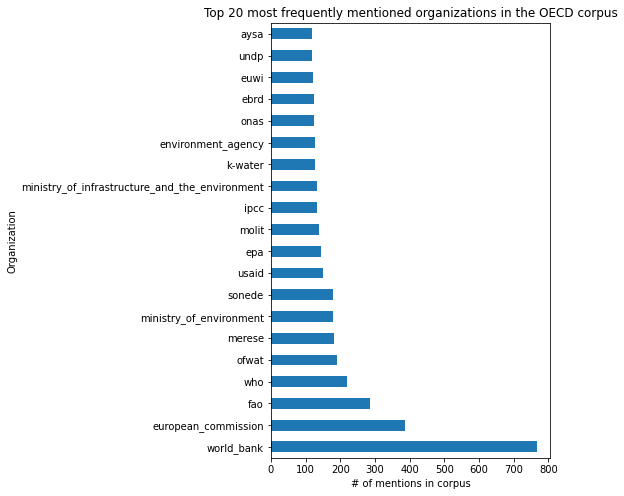

In [13]:
# temporarily remove some frequently occuring entities from the analysis
org_df = org_df[~org_df['entity_as_single_token'].isin(['oecd', 'ec', 'pmu', 'ministry_of_finance'])]
# plot entity frequencies
pl = org_df['entity_as_single_token'].value_counts()[:20].plot(kind='barh', title='Top 20 most frequently mentioned organizations in the OECD corpus', figsize=(5,8))
pl.set_xlabel("# of mentions in corpus")
pl.set_ylabel("Organization")

### 3a. Further explore ORGs (organisations) only 

Plot top N most frequently mentioned entities in each doc

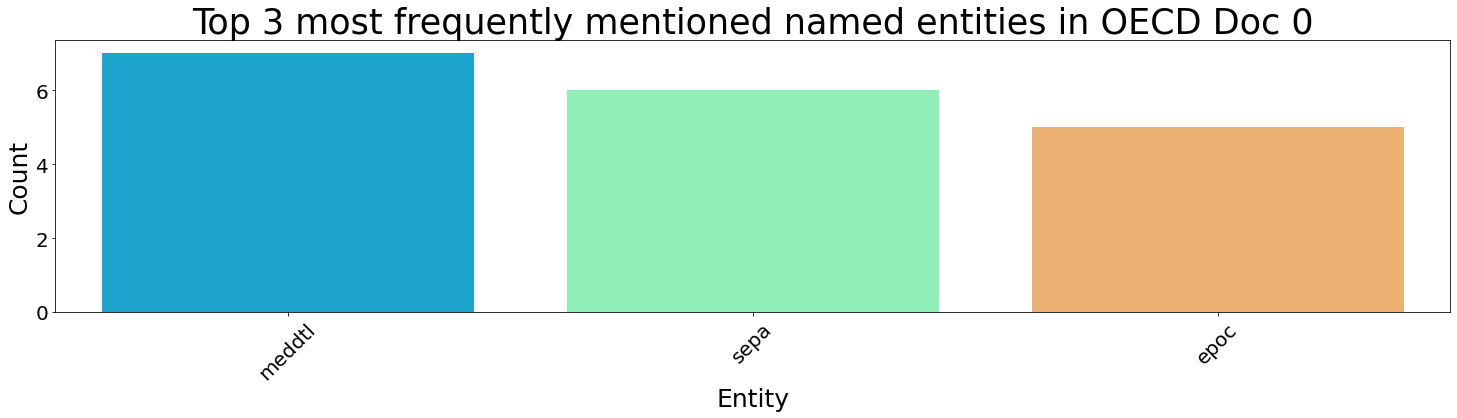

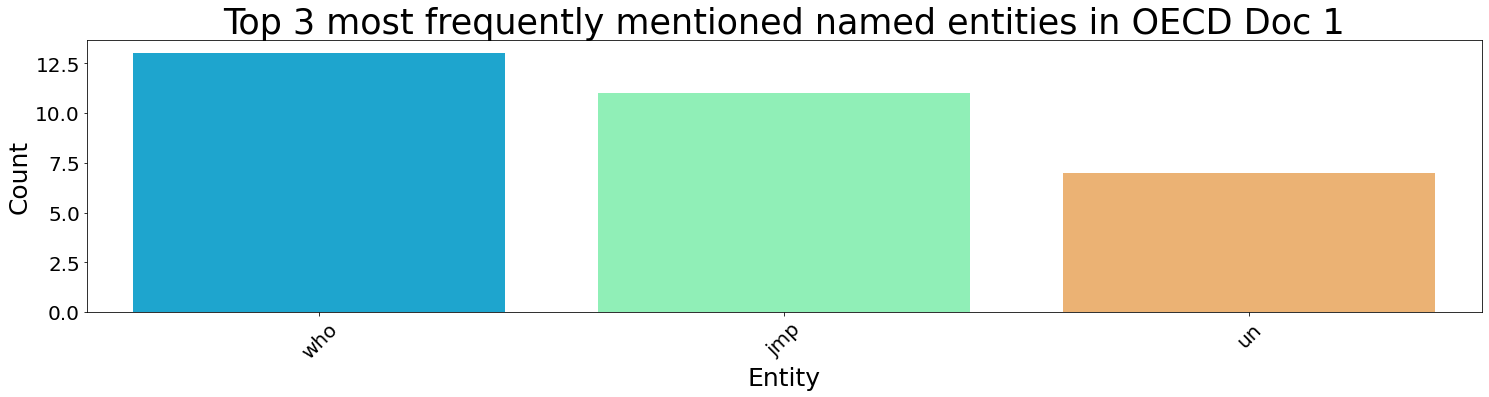

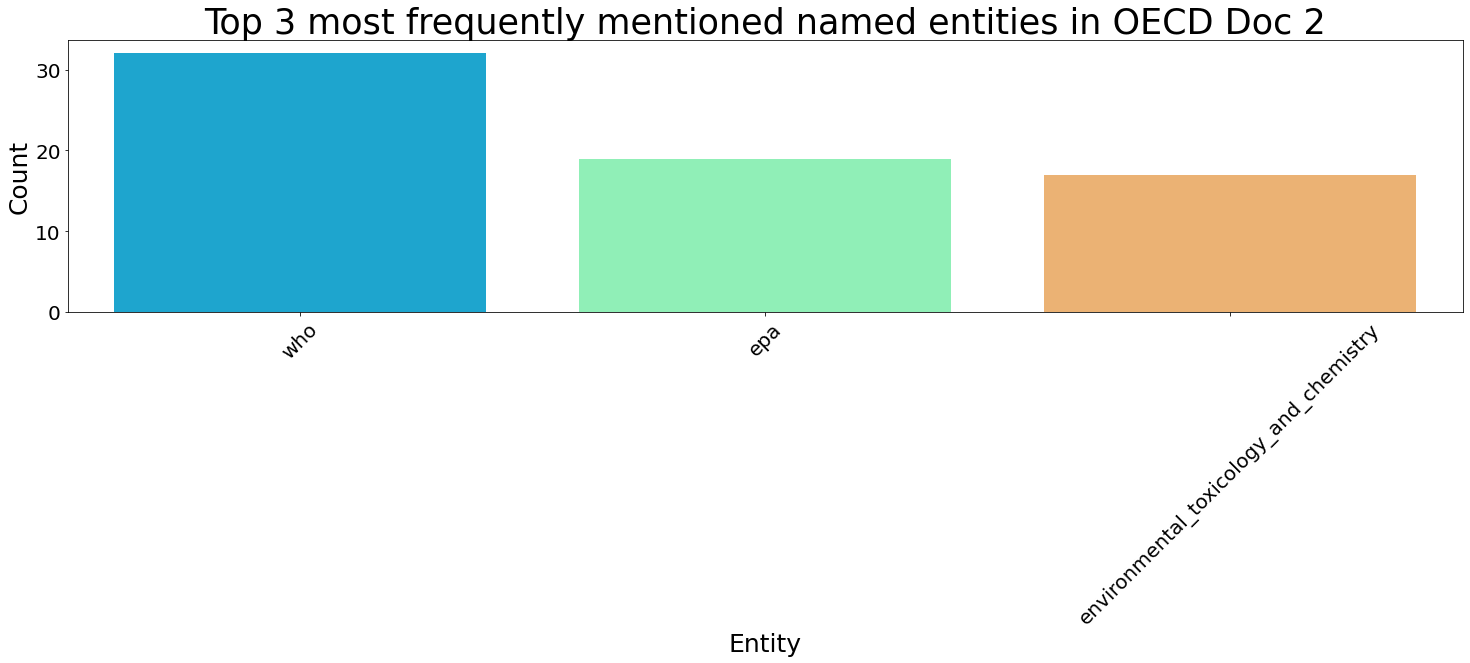

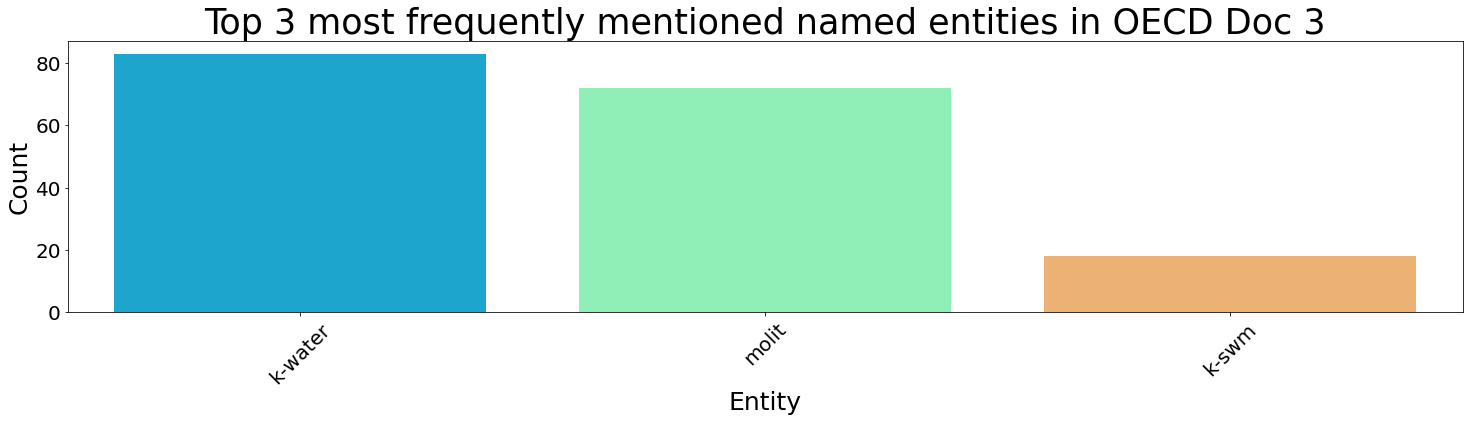

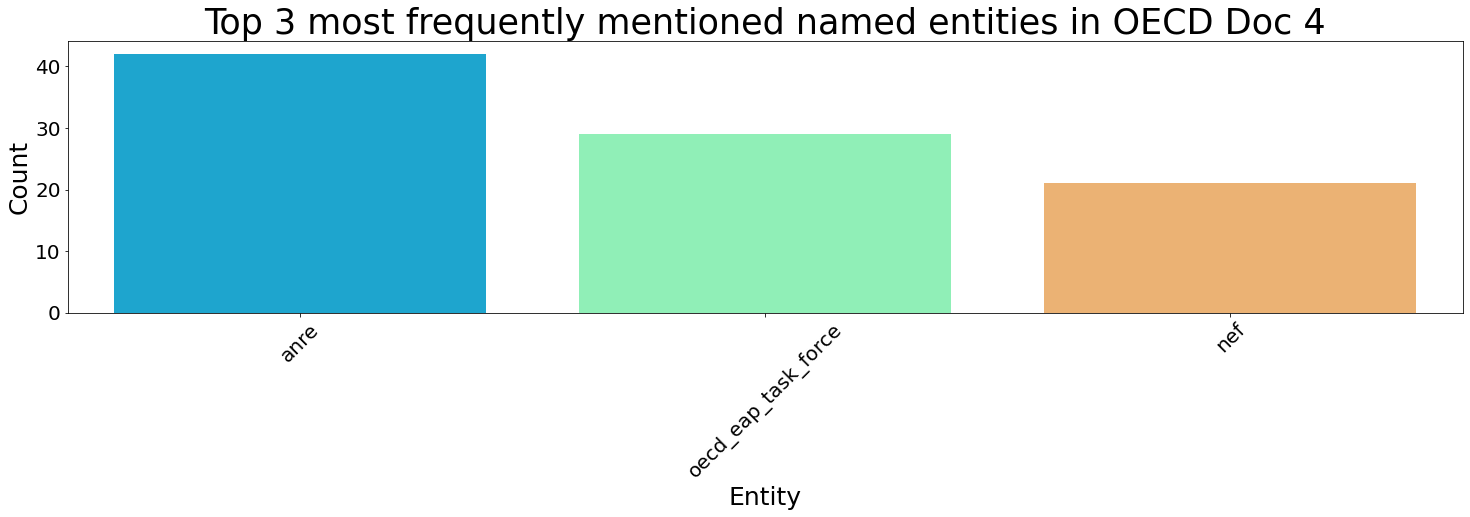

In [14]:
import pandas as pd
import seaborn as sns
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

def get_topn_entities_from_all_docs(n):
    # group frequency of named entities by document
    org_df_onlydocs_and_ents = org_df.drop(['entity_type', 'sentence', 'span', 'model'], axis=1)
    org_df_onlydocs_and_ents.reset_index()
    filtered = org_df_onlydocs_and_ents.groupby('docid')['entity_as_single_token'].value_counts()
    filtered = filtered.reset_index(name='count')
    topn_df = pd.DataFrame()

    for item in pd.unique(filtered['docid']):
        curr_dataf = filtered[filtered['docid'] == item]
        topn_df = pd.concat([topn_df, curr_dataf.head(n)], axis=0)
        
    return topn_df

def plot_topn_entities_in_doc(n, docid):
    topn_df = get_topn_entities_from_all_docs(n)
    plt.figure(figsize=(25,5))
    s = sns.barplot(x='entity_as_single_token', y='count', data=topn_df[topn_df['docid'] == docid], palette='rainbow')
    s.axes.set_title("Top " + str(n) + " most frequently mentioned named entities in OECD Doc " + str(docid), fontsize=35)
    s.set_xlabel("Entity",fontsize=25)
    s.set_ylabel("Count",fontsize=25)
    s.tick_params(labelsize=20)
    plt.xticks(rotation=45)

plot_topn_entities_in_doc(3, 0) # doc 0
plot_topn_entities_in_doc(3, 1) # doc 1
plot_topn_entities_in_doc(3, 2) # doc 2
plot_topn_entities_in_doc(3, 3) # doc 3
plot_topn_entities_in_doc(3, 4) # doc 4


### 3b. Further explore ORGs (organisations) only 

Generate document - term frequency matrix for top N most frequently mentioned entities in each document.

In [17]:
# Generate word frequency matrix
import numpy as np

n = 3 # assign n
topn_df = get_topn_entities_from_all_docs(n) # top n mentioned entities in each doc
    
entities = list(set(topn_df['entity_as_single_token'].tolist()))
docs = list(set(topn_df['docid'].tolist()))
docs.sort()
matr = []
# print(topn_df)
for docid in docs:
    tmp = []
    for entity in entities:
        # print(type(entity))
        curr_row = topn_df.loc[(topn_df['entity_as_single_token'] == entity) & (topn_df['docid'] == docid)]
        if len(curr_row) == 0:
            tmp.append(0)
        else:
            # print(curr_row['count'].values[0])
            tmp.append(curr_row['count'].values[0])
    matr.append(tmp)

### 3c. Further explore ORGs (organisations) only 

Plot the document - term frequency matrix for top N most frequently mentioned entities in each document.

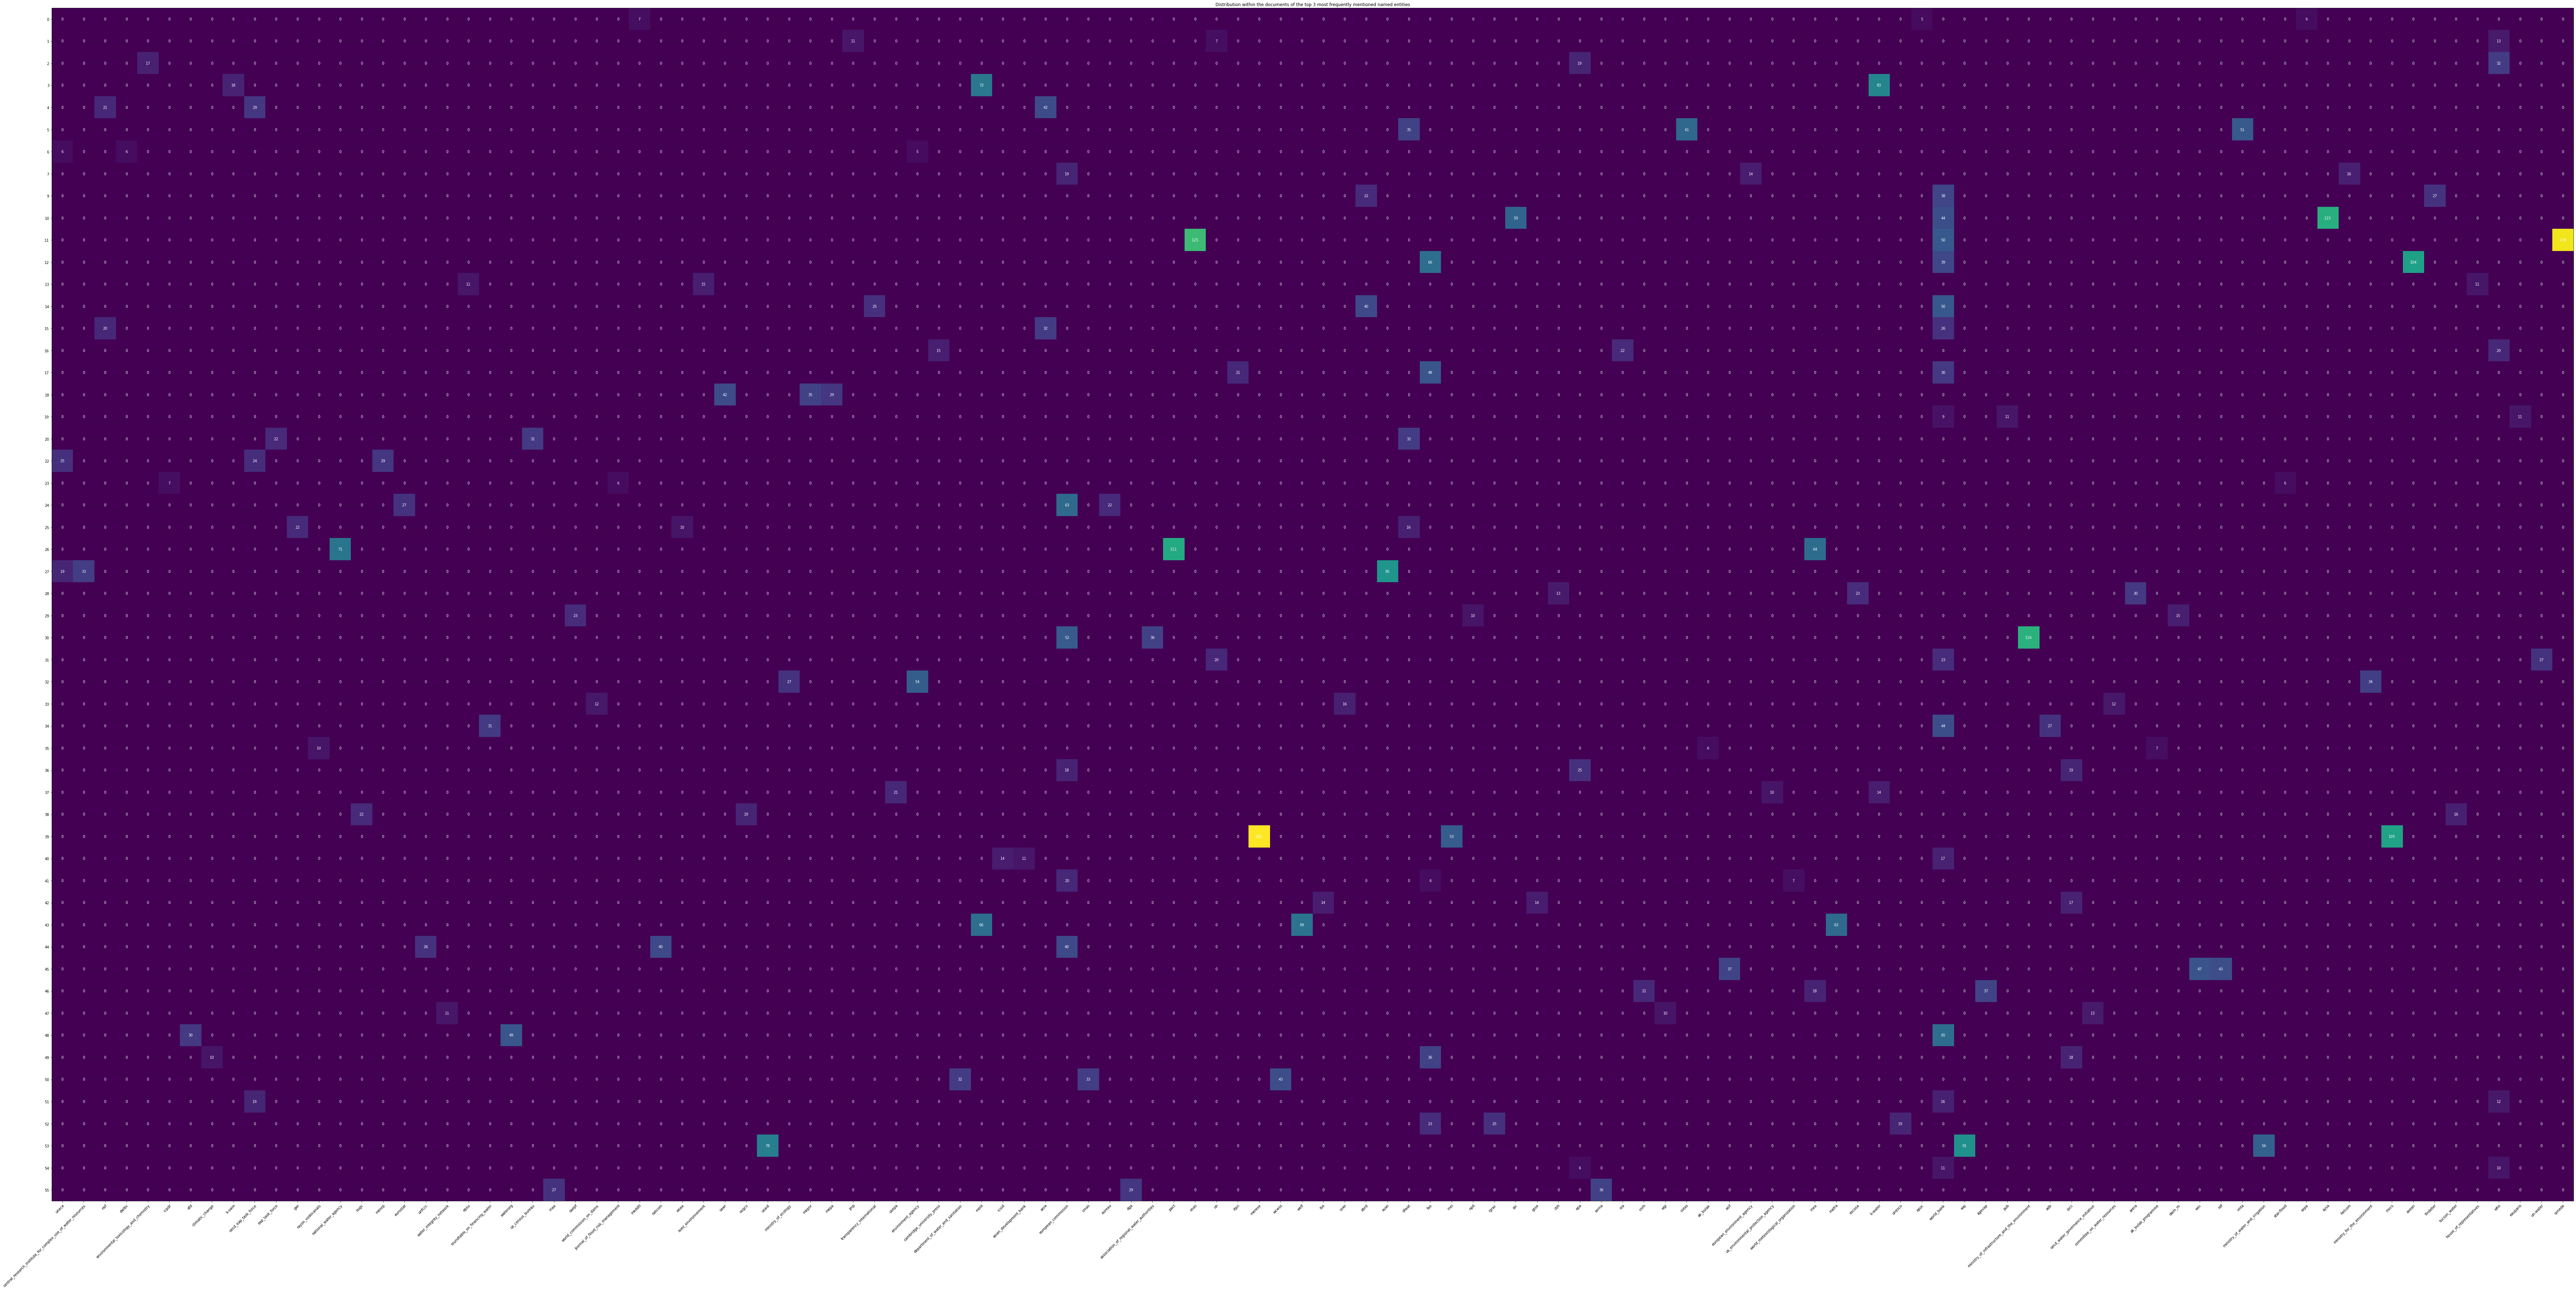

In [19]:
# Plot word frequency matrix 
matrix = np.array(matr)

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(100, 50))
im = ax.imshow(matrix, aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(entities)), labels=entities)
ax.set_yticks(np.arange(len(docs)), labels=docs)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(docs)):
    for j in range(len(entities)):
        text = ax.text(j, i, matrix[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Distribution within the documents of the top " + str(n) + " most frequently mentioned named entities")
fig.tight_layout()
plt.show()

### 3d. Further explore ORGs (organisations) only 

Calculate [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) scores for each organization

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import pandas as pd

In [21]:
from preprocessing import replace_ngrams_with_unigrams_curated_phrases, preprocess_word2vec

with open(os.path.join(data_dir, "processed_ngram_ner_data.json")) as f:
    data = json.load(f)

# combine all docs into one string
documents = []
for item in data:
    documents.append(preprocess_word2vec(data[item], custom_stopwords=None))

In [23]:
# compute tfidf scores
documents_ = []
for item in documents:
    doc_str = ''
    for sent in item:
        tmp = ' '.join(sent)
        doc_str +=  tmp + ' '
    documents_.append(doc_str)
    
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(documents_)
feature_names = vectorizer.get_feature_names_out()

In [24]:
# process results of tfidf scores (only keep organizations and remove duplicates)
dict(zip(vectorizer.get_feature_names(), X.toarray()[0]))

res = []

for i in range(0,len(documents_)):
    feature_index = X[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[i, x] for x in feature_index])
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        if (w in (list(set(org_df['entity_as_single_token'].tolist())))):
            res.append([w, s])
            
# save results to dataframe and file
tfidf_df = pd.DataFrame(res, columns=['org_name', 'tfidf_score'])
tfidf_df.to_csv(os.path.join(data_dir, 'tfidf_scores.csv'),index=False)

In [14]:
orgsonly = org_df[org_df['entity_type'] == 'ORG'] # get only ORGs from source dataframe
tfidf_df.sort_values(by=['tfidf_score'], ascending=False, inplace=True) # sort tfidf dataframe by tfidf scores descending order
torg = tfidf_df[tfidf_df['org_name'].isin(orgsonly['entity_as_single_token'].tolist())] # filter tfidf dataframe only for ORGs
torg.sort_values(by=['tfidf_score'], ascending=False, inplace=True) # sort tfidf dataframe again by tfidf scores descending order
t = torg.groupby('org_name').head(1) # there may be multiple tfidf scores for the same organisation, filter only the one with the highest tfidf score
t.to_csv(os.path.join(data_dir, 'tfidf_sorted_full.csv'), index=False) # save tfidf dataframe to file


,org_name,tfidf_score
1132,national_water_supply_and_distribution_company,0.409998
1442,association_of_southeast_asian_nations,0.306480
1131,national_sanitation_office,0.268823
3264,welf,0.246482
3553,water_authority_of_jordan,0.232871
...,...,...
6865,national_indian_foundation,0.000659
6866,environmental_licensing_directorate,0.000659
6867,directorate_of_water_and_territories_management,0.000659
6861,national_secretariat_for_environmental_sanitation,0.000659
